<a href="https://colab.research.google.com/github/iey704/ComputerVision/blob/main/CV_AL2_EfficientNetv2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   AdamP optimizer 사용
*   Label Smoothing = 0.03
*   EfficientNet 모델 사용
* Data Augmentation:Geomentric transform + Visual corruptions





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d7b0e4fa58ecb871a951c09192cd058743e4290a3edfc9024b9375a9c5dbee9d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
!pip3 install adamp

  Preparing metadata (setup.py) ... done
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5982 sha256=e39dc5840815b24140162f5f8fba53315b775ced7dbe900abdaecd4291a6454b
  Stored in directory: /root/.cache/pip/wheels/c7/ad/0f/b41b1c45b18c66e5eef5d2254415af8055c7e2b0934145157d
Successfully built adamp


In [4]:
import os
import time

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image,ImageEnhance

from efficientnet_pytorch import EfficientNet

from torch.utils.data import ConcatDataset
from collections import Counter

from adamp import AdamP

# 랜덤 시드 설정 공통
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### GPU Setting ###
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print(DEVICE)

cuda


In [5]:
### Custom Dataset ###
class CUB2011(Dataset):
  def __init__(self, transform, mode='train'):
    self.transform = transform
    self.mode = mode

    if self.mode == 'train':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/train')
    elif self.mode == 'valid':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/valid')
    elif self.mode == 'test':
      self.image_folder = os.listdir('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets/test')

  def __len__(self):
    return len(self.image_folder)

  def __getitem__(self, idx):
    img_path = self.image_folder[idx]
    img = Image.open(os.path.join('/content/gdrive/MyDrive/Colab Notebooks/CUB_200_2011_repackage_class50/datasets', self.mode, img_path)).convert('RGB')
    img = self.transform(img)
    label = img_path.split('_')[-1].split('.')[0]
    label = int(label)
    return (img, label)

In [6]:
# Geomentric transform + Visual corruptions
class AddGaussianNoise(object):
    def __init__(self, mean=0, std=1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if np.random.rand() < self.p:
            img_array = np.array(img)
            noise = np.random.normal(self.mean, self.std, img_array.shape)
            noisy_image = np.clip(img_array + noise, 0, 255)  # Clip values to the range [0, 255]
            return Image.fromarray(noisy_image.astype(np.uint8))
        else:
            return img

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std}, p={self.p})'


class AdjustContrast(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

class AdjustBrightness(object):
    def __init__(self, factor=1.0):
        self.factor = factor

    def __call__(self, img):
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(self.factor)
        return img

    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'

In [7]:
### Data Preprocessing & Data Augmentation ###
transforms_train_origin = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),])

transforms_test = transforms.Compose([
    transforms.Resize((448,448)),
    transforms.ToTensor(),])

# Geomentric transform + Visual corruptions
transforms_train_g_v = transforms.Compose([
    transforms.Resize((448, 448)),
    #transforms.RandomResizedCrop(448),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(30),
    AddGaussianNoise(mean=0, std=25, p=0.5),  # 가우시안 노이즈를 추가합니다.
    AdjustContrast(factor=2.0),  # 대비를 조절합니다.
    AdjustBrightness(factor=1.5),  # 밝기를 조절합니다.
    transforms.ToTensor(),
])

BATCH_SIZE = 8

train_set_origin = CUB2011(mode='train',
                    transform=transforms_train_origin)
val_set = CUB2011(mode='valid',
                  transform=transforms_test)
test_set = CUB2011(mode='test',
                  transform=transforms_test)

train_set_augmented2 = CUB2011(mode='train',transform=transforms_train_g_v) # 2)

train_loader = DataLoader(train_set_origin,batch_size=BATCH_SIZE,shuffle=True)

# 다 합친거
train_set_combined = ConcatDataset([train_set_origin,train_set_augmented2])

print('Num of each dataset: ',len(train_set_combined),len(val_set),len(test_set))

# Dataloader class는 bath기반의 딥러닝모델 학습을 위해서 mini batch를 만들어주는 역할을 한다
# dataloader를 통해 dataset의 전체 데이터가 batch size로 나뉘게 된다
train_loader = DataLoader(train_set_combined, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=False)

print("Loaded dataloader")

Num of each dataset:  4720 296 298
Loaded dataloader


In [8]:
### Model / Optimizer ###
EPOCH = 20
lr = 0.0001

model = torch.hub.load('hankyul2/EfficientNetV2-pytorch', 'efficientnet_v2_s', pretrained=True, nclass=50)
print(model)

### Tranfer Learning ###
'''
num_features = model.classifier.in_features
model.fc = nn.Linear(num_features,50)
'''
model.to(DEVICE)

optimizer = AdamP(model.parameters(), lr=lr)

print("Created a learning model and optimizer")

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/hankyul2/EfficientNetV2-pytorch/zipball/main" to /root/.cache/torch/hub/main.zip


EfficientNetV2(
  (stem): ConvBNAct(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (blocks): Sequential(
    (0): MBConv(
      (block): Sequential(
        (fused): ConvBNAct(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (stochastic_path): StochasticDepth()
    )
    (1): MBConv(
      (block): Sequential(
        (fused): ConvBNAct(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU()
        )
      )
      (stochastic_path): StochasticDepth()
    )
    (2): MBConv(
      (block): Sequential(
  

In [9]:
### Train/Evaluation ###
def train(model,train_loader,optimizer,epoch):
  model.train()
  criterion = nn.CrossEntropyLoss(label_smoothing=0.03)
  for i,(image,target) in enumerate(train_loader):
    image,target = image.to(DEVICE),target.to(DEVICE)
    output = model(image)
    optimizer.zero_grad()
    train_loss = criterion(output,target)

    train_loss.backward()
    optimizer.step()

    if i%10 ==0:
      print(
          f'Train Epoch: {epoch} [{i}/{len(train_loader)}]\tloss: {train_loss.item():6f}')

  return train_loss

def evaluate(model,val_loader):
  model.eval()
  eval_loss = 0
  correct = 0
  with torch.no_grad():
    for i,(image,target) in enumerate(val_loader):
      image,target = image.to(DEVICE),target.to(DEVICE)
      output = model(image)

      eval_loss += F.cross_entropy(output,target, reduction='sum').item()
      pred = output.max(1,keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()

  eval_loss /= len(val_loader.dataset)
  eval_accuracy = 100*correct / len(val_loader.dataset)
  return eval_loss,eval_accuracy

In [10]:
### Main ###
start = time.time()
best = 0
train_losses = []  # 훈련 손실을 저장할 목록
val_losses = []    # 검증 손실을 저장할 목록
val_accuracys = []

for epoch in range(EPOCH):
  train_loss = train(model,train_loader,optimizer,epoch)
  val_loss,val_accuracy = evaluate(model,val_loader)

# 훈련 및 검증 손실을 목록에 추가
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  # Save best model
  if val_accuracy > best:
    best = val_accuracy
    torch.save(model.state_dict(),"./best_model.pth")

  val_accuracys.append(val_accuracy)
  print(f"[{epoch}]Validation Loss: {val_loss:.4f},Accuracy: {val_accuracy:.4f}%")

# Test result
test_loss,test_accuracy = evaluate(model,test_loader)
print(f'[FINAL] Test Loss: {test_loss:.4f},Accuracy: {test_accuracy:.4f}%')

end = time.time()
elasped_time = end - start

print("Best Accuracy: ",best)
print(
    f"Elasped Time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")
print(
    f"time: {int(elasped_time/3600)}h, {int(elasped_time/60)}m, {int(elasped_time%60)}s")

Train Epoch: 0 [0/590]	loss: 3.888274
Train Epoch: 0 [10/590]	loss: 3.945460
Train Epoch: 0 [20/590]	loss: 3.925065
Train Epoch: 0 [30/590]	loss: 3.862766
Train Epoch: 0 [40/590]	loss: 3.897292
Train Epoch: 0 [50/590]	loss: 3.847075
Train Epoch: 0 [60/590]	loss: 3.819253
Train Epoch: 0 [70/590]	loss: 3.681778
Train Epoch: 0 [80/590]	loss: 3.709159
Train Epoch: 0 [90/590]	loss: 3.545372
Train Epoch: 0 [100/590]	loss: 3.597523
Train Epoch: 0 [110/590]	loss: 3.745451
Train Epoch: 0 [120/590]	loss: 3.562643
Train Epoch: 0 [130/590]	loss: 3.729594
Train Epoch: 0 [140/590]	loss: 3.477667
Train Epoch: 0 [150/590]	loss: 3.461898
Train Epoch: 0 [160/590]	loss: 3.244741
Train Epoch: 0 [170/590]	loss: 3.212757
Train Epoch: 0 [180/590]	loss: 3.192868
Train Epoch: 0 [190/590]	loss: 3.137543
Train Epoch: 0 [200/590]	loss: 3.001417
Train Epoch: 0 [210/590]	loss: 2.791223
Train Epoch: 0 [220/590]	loss: 2.954462
Train Epoch: 0 [230/590]	loss: 2.961124
Train Epoch: 0 [240/590]	loss: 2.799040
Train Epoch

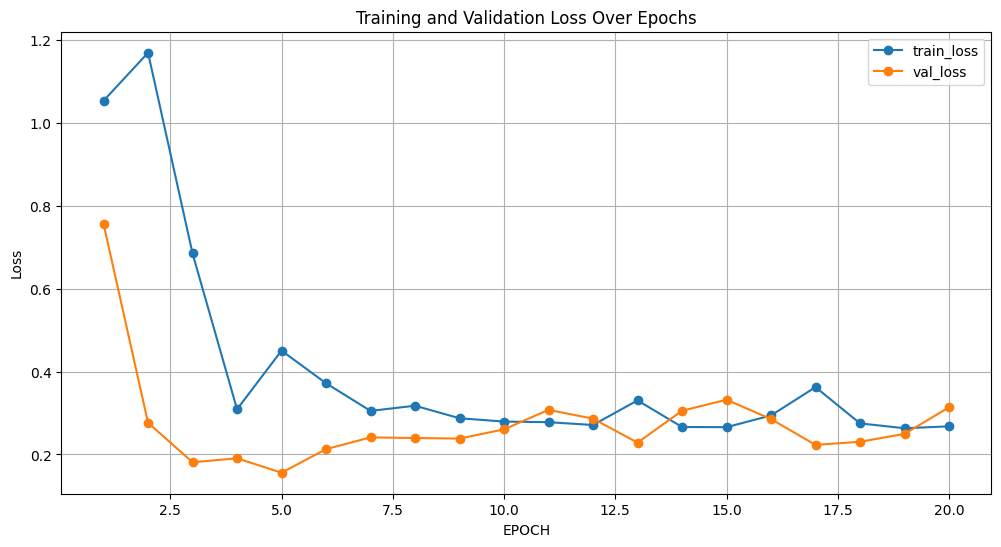

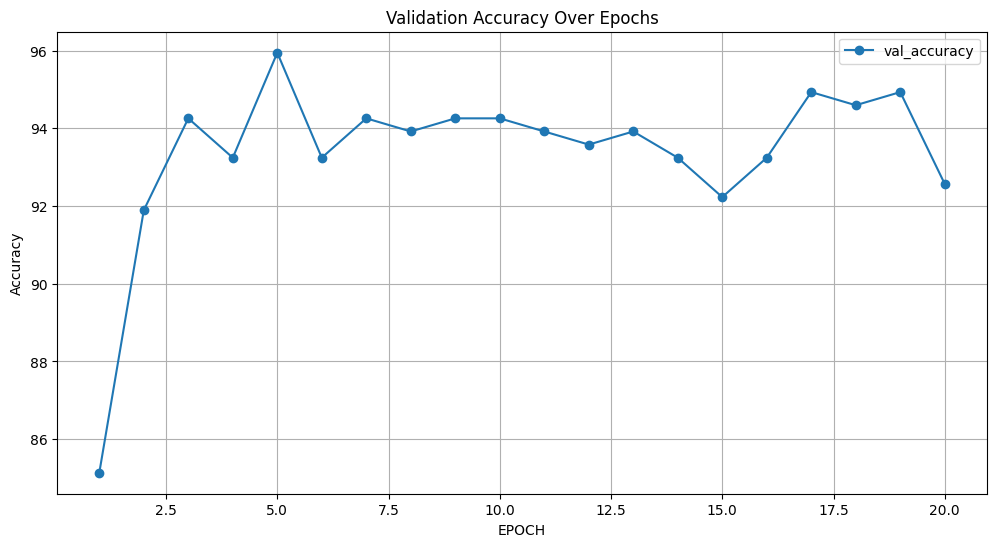

In [11]:
# 이제 손실 값을 플로팅합니다.
import matplotlib.pyplot as plt

# train_loss와 val_loss 텐서를 CPU로 이동하고 NumPy 배열로 변환
train_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses]
val_losses = [loss.cpu().detach().numpy() if isinstance(loss, torch.Tensor) else loss for loss in val_losses]

plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), train_losses, label='train_loss', marker='o')
plt.plot(range(1, EPOCH + 1), val_losses, label='val_loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


val_accuracys = [acc.cpu().detach().numpy() if isinstance(acc, torch.Tensor) else acc for acc in val_accuracys]
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCH + 1), val_accuracys, label='val_accuracy', marker='o')
plt.title('Validation Accuracy Over Epochs')

plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()